# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [ ]:
#!pip install -qq datasets
#!pip install -qq evaluate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [66]:
import gc
import numpy as np
import pandas as pd
import evaluate
from collections import deque
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from datasets import load_dataset
from torch.optim import AdamW
from torch.utils.data import DataLoader
import transformers
import torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, get_scheduler

In [27]:
print(f"Transformers version: {transformers.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Transformers version: 4.51.3
PyTorch version: 2.7.0+cu128
CUDA available: True


In [28]:
RANDOM_STATE = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [29]:
data = pd.read_csv("datasets/toxic_comments.csv")  # перед отправкой добавить /

In [30]:
data.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [31]:
data['toxic'].value_counts()

toxic
0    143106
1     16186
Name: count, dtype: int64

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [33]:
data = data[['text', 'toxic']]
data.columns = ['text', 'labels']

<Axes: >

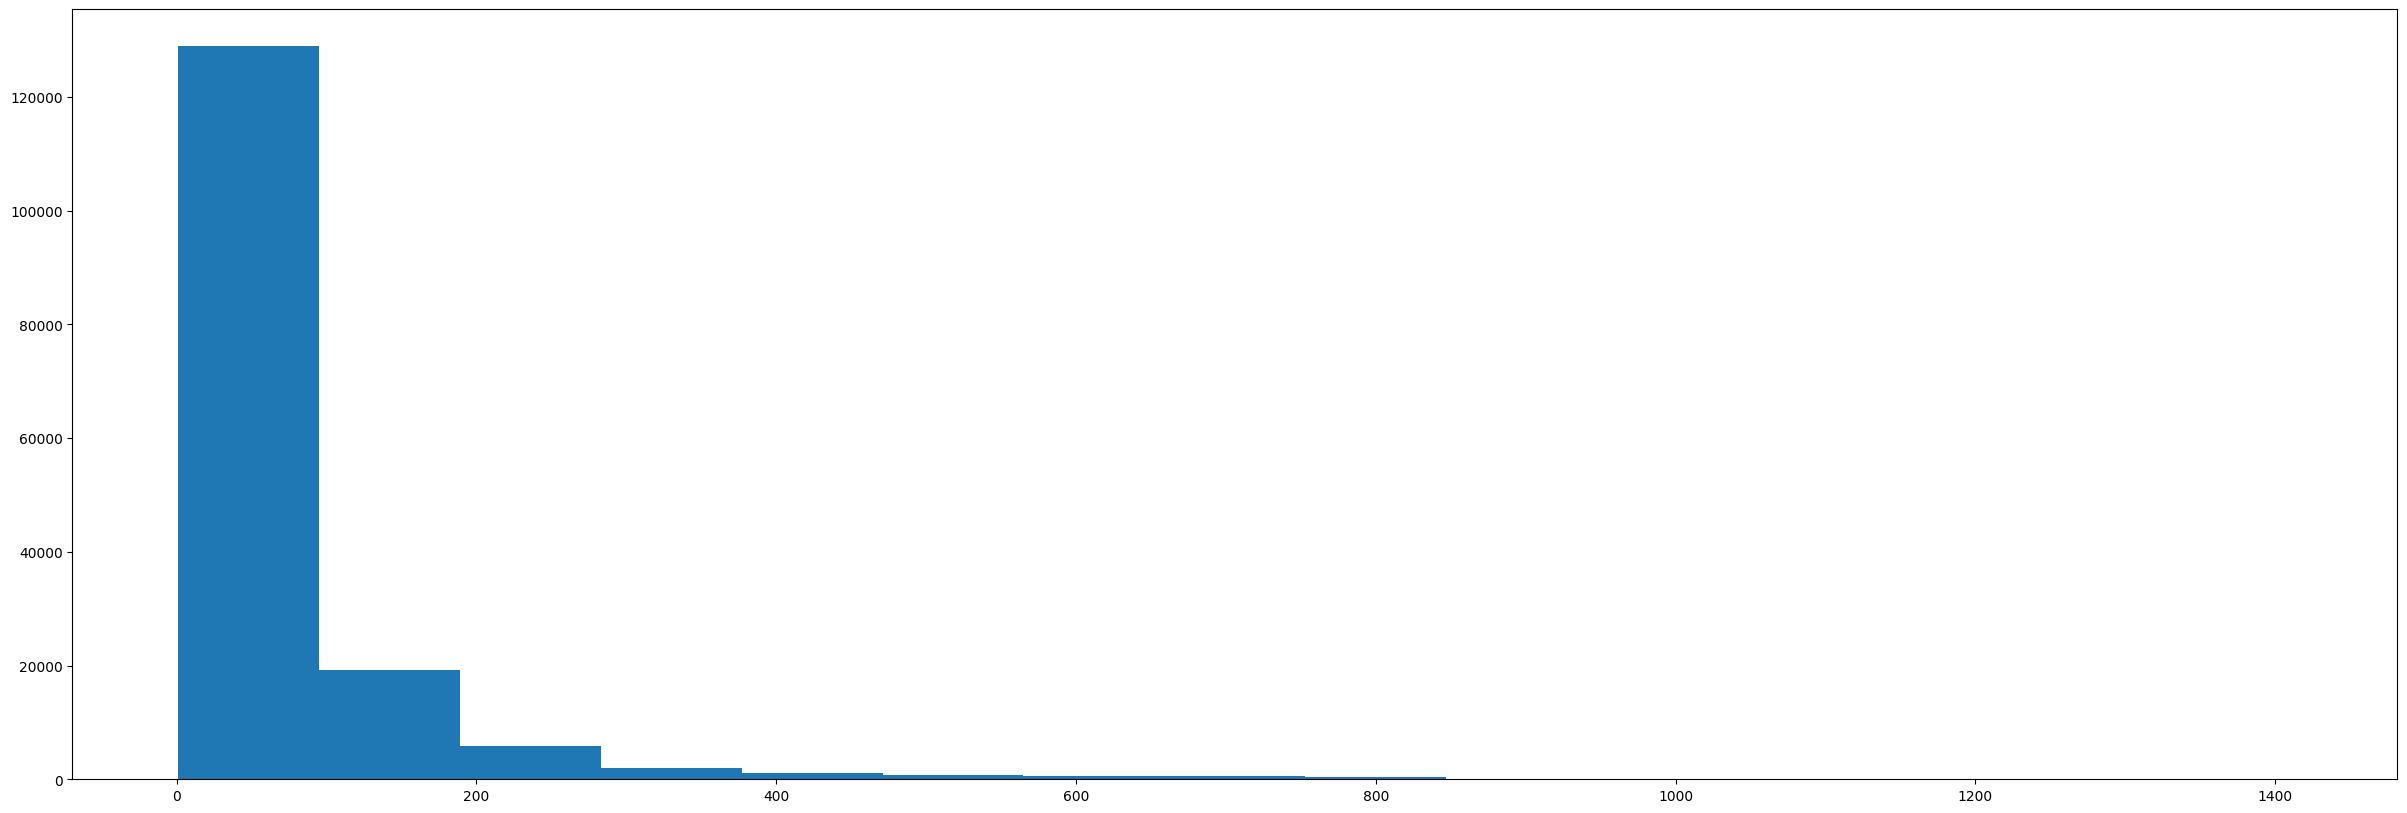

In [34]:
data['text'].apply(lambda x: len(x.split())).hist(figsize=(30, 10), bins=15, grid=False)

In [35]:
data = data.sample(frac=1).reset_index(drop=True)
train = data[:int(len(data)*0.8)]
test =  data[int(len(data)*0.8):]

In [36]:
len(train), len(test)

(127433, 31859)

In [37]:
print(len(train['labels'].value_counts()))

2


In [38]:
print(len(test['labels'].value_counts()))

2


In [39]:
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

## Обучение

In [40]:
model_name = "sberbank-ai/sbert_large_nlu_ru"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sberbank-ai/sbert_large_nlu_ru and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
names = list(model.named_parameters())
names[:6]

[('bert.embeddings.word_embeddings.weight',
  Parameter containing:
  tensor([[ 0.0606, -0.0615,  0.0168,  ..., -0.0138, -0.0484, -0.0585],
          [ 0.0038, -0.0852,  0.0023,  ..., -0.0053,  0.0156, -0.0284],
          [ 0.0240, -0.0408, -0.0073,  ..., -0.0014,  0.0304,  0.0227],
          ...,
          [ 0.0440, -0.0153,  0.0383,  ..., -0.0643, -0.0344, -0.0135],
          [ 0.0465, -0.0162,  0.0522,  ..., -0.0459,  0.0222, -0.0480],
          [ 0.0326,  0.0194,  0.0508,  ...,  0.0417, -0.0545, -0.0163]],
         requires_grad=True)),
 ('bert.embeddings.position_embeddings.weight',
  Parameter containing:
  tensor([[ 3.9556e-04,  1.1412e-02, -7.9491e-03,  ..., -2.6713e-04,
           -3.0242e-03, -1.2221e-02],
          [-4.3789e-03,  8.2686e-03,  7.2317e-03,  ...,  5.0034e-03,
            2.9022e-03,  1.4276e-03],
          [ 5.3956e-03,  2.1844e-02,  1.8691e-02,  ..., -1.1598e-03,
           -3.7614e-03, -3.7767e-05],
          ...,
          [-4.0377e-03, -8.1262e-03, -1.7772e

In [ ]:
torch.cuda.empty_cache()
gc.collect()

9

In [43]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

In [44]:
dataset = load_dataset('csv', data_files={'train': 'train.csv', 'test': 'test.csv'})

Generating train split: 127433 examples [00:00, 295961.44 examples/s]
Generating test split: 31859 examples [00:00, 296223.30 examples/s]


In [45]:
dataset = dataset.map(lambda x: tokenizer(x['text'], truncation = True, max_length=255, padding='max_length'), batched=True)

Map: 100%|██████████| 31859/31859 [00:03<00:00, 8624.49 examples/s] 


In [46]:
pytorch_style_columns = ['input_ids', 'token_type_ids', 'attention_mask', 'labels']  
dataset = dataset.remove_columns(list(set(list(dataset['train'].features.keys())) - set(pytorch_style_columns)))

In [47]:
dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 127433
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 31859
    })
})

In [ ]:
#переврдим в формат пайторча
# сразу грузим на gpu, если есть cuda, иначе девайс стоит убрать из аргумента
dataset.set_format(type='torch', columns=pytorch_style_columns, device='cuda')

In [ ]:
# установить 3 или больше, если более 16 гб видеопамяти
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=3)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=1)

In [51]:
len(train_dataloader)

42478

In [ ]:
optimizer = AdamW(model.parameters(), lr=2e-6)
num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
# будем линейно увеличивать первые 200 шагов
lr_scheduler = get_scheduler(
    "constant_with_warmup",
    optimizer=optimizer,
    num_warmup_steps=2000,
    num_training_steps=num_training_steps
)

In [54]:
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# лучший f1, по нему будем сохранять
best_f1 = 0.
# средний loss
avg_loss = deque([], maxlen=30)

# проходимся по всем эпохам
for epoch in range(num_epochs):
    # отображаем номера эпох
    print(40*'-', '\nepoch', epoch+1)
    # переводим в режим тренировки
    model.train()
    # итерируемся по треин части
    with tqdm(train_dataloader, unit="batch") as tepoch:
        for batch in tepoch:
            # переводим в режим тренировки
            model.train()
            # print(batch)
            # переносим батч на гпу, где и модель
            batch = {k: v.to(device) for k, v in batch.items()}
            # print(batch)
            # получаем прогнозы
            outputs = model(**batch)
            # print(outputs)
            # получаем лосс встроенный вместе с моделью (кросс-энтропия)
            loss = outputs.loss
            # делаем обратный проход
            loss.backward()
            # шаг по градиенту
            optimizer.step()
            # шаг по скорости
            lr_scheduler.step()
            # шаг по оптимизатору
            optimizer.zero_grad()
            # фиксируем потери на треин
            avg_loss.append(loss.item())
            # добавляем в прогрессбар информацию о среднем лоссе за 30 батчей
            tepoch.set_postfix(loss=np.array(list(avg_loss)).mean())

    losses = []
    # валидируемся в конце эпохи
    print('\nvalidating')
    # загружаем все основные метрики
    f1 = evaluate.load('f1')
    acc = evaluate.load('accuracy')
    precision = evaluate.load('precision')
    recall = evaluate.load('recall')
    with torch.no_grad():
        # переводим в режим валидации
        model.eval()
        # проходимся по всем батчам из теста
        for batch in tqdm(test_dataloader):
            # переносим их на гпу
            batch = {k: v.to(device) for k, v in batch.items()}
            # не обновляя параметры получаем прогнозы
            with torch.no_grad():
                outputs = model(**batch)
            # получаем сразу логиты
            logits = outputs.logits
            # находим верный ответ
            predictions = torch.argmax(logits, dim=-1)
            # логируем в метрики по f1
            f1.add_batch(predictions=predictions, references=batch["labels"])
            acc.add_batch(predictions=predictions, references=batch["labels"])
            precision.add_batch(predictions=predictions, references=batch["labels"])
            recall.add_batch(predictions=predictions, references=batch["labels"])
        # находим взвешенные по кол-ву примеров на тест метрики
        print('weighted summary:')
        print('Test acc:', acc.compute()['accuracy'])
        print('Test precision:', precision.compute(average = 'weighted')['precision'])
        print('Test recall:', recall.compute(average = 'weighted')['recall'])
        f1_weighted = f1.compute(average = 'weighted')['f1']
        print('Test f1:', f1_weighted, '\n')
        # если текущая f1 лучше максимальной
        if f1_weighted > best_f1:
            # максмальная становится текущей
            best_f1 = f1_weighted
            # сохраняем модель
            model.save_pretrained(f"best_model_f1_max={best_f1}_len=255")

    # переводим обратно в режим тренировки для следующей эпохи
    model.train()

---------------------------------------- 
epoch 1


100%|██████████| 42478/42478 [2:27:03<00:00,  4.81batch/s, loss=0.0323]   



validating


100%|██████████| 31859/31859 [09:19<00:00, 56.96it/s]


weighted summary:
Test acc: 0.9664772905615368
Test precision: 0.9652726563035476
Test recall: 0.9664772905615368
Test f1: 0.965237468001005 



In [67]:
# валидируем по тесту
# реальные ответы и предсказания
true = []
preds = []

# переводим модель в режим инференса
model.eval()
# проходимся по батчам теста
for batch in tqdm(test_dataloader):
    # переносим батч на GPU
    batch = {k: v.to(device) for k, v in batch.items()}
    # без обновления параметров находим прогнозы
    with torch.no_grad():
        outputs = model(**batch)
    # получаем логиты
    logits = outputs.logits
    # из логитов прогноз
    predictions = torch.argmax(logits, dim=-1)
    # добавляем пачки ответов и прогнозов в массивы
    true += batch["labels"].detach().cpu().numpy().tolist()
    preds += predictions.detach().cpu().numpy().tolist()

100%|██████████| 31859/31859 [08:39<00:00, 61.34it/s]


In [68]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     28619
           1       0.90      0.76      0.82      3240

    accuracy                           0.97     31859
   macro avg       0.93      0.87      0.90     31859
weighted avg       0.97      0.97      0.97     31859



## Выводы

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Данные загружены и подготовлены
- [ ]  Модели обучены
- [ ]  Значение метрики *F1* не меньше 0.75
- [ ]  Выводы написаны